# Charleston Shipping Lanes Risk Analysis

### Research Question

> Presently, there are no recommended lanes off Charleston. Would recommended lane/s reduce the relative risk of interactions between commercial vessels and right whales? Can it be determined?  If so, what is the expected reduction in risk of interactions and where should the lanes be placed? 

### Suggested Approach

Following Fonnesbeck *et al.* (2008), we will construct a predictive model of right whale occurrence that is based on existing aerial survey data and relevant environmental predictors of whale habitat use, such as bathymetry and water temperature. This model will be used as a tool to identify a shipping lane designation that minimizes risk to the migratory northern right whale population.

The metric for risk for a particular lane designation will be the mean probability of co-occurrence of ships and whales over the total area defined by any candidate lane. To avoid having to account for small-scale factors related to the interaction of whales and ships, risk will be estimated at a relatively coarse scale. Specifically, I will estimate the expected occurrence probability of whales over the cells of a 4km grid.

A key component of the modeling approach is the estimation of the probability of occupancy in each grid cell, for a particular month. Occupancy is simply the probability that one or more animals currently occupies a grid cell. Estimates of occupancy are informed by aerial survey data, which includes both sightings and on-watch effort. While a sighting comprises evidence that a grid cell is occupied, the absence of a sighting may indicate either that a cell is not occupied, or that a cell is occupied but the animals were simply not detected by observers.

The probability of one or more detections in a given grid cell $i$ during a given month can be expressed as the complement of the probability of no detections. In turn, the probability of no detections during a given month is the product of the probability of observing no groups ($y_{ij} = 0$) on each survey day $j$. We assume that these daily probabilities are approximately equal, so this is the daily probability $Pr(y_i = 0)$ raised to the number of survey days $n$:

$$\pi_i = 1 - \prod_{j=1}^n Pr(y_{ij}=0) = 1 - [Pr(y_i=0)]^n$$

Encounter probabilities will be estimated for each month of the year, to account for the seasonal migratory movement of whales. To aid the predictive performance of the model, we will use covariates to estimate monthly encounter probabilities; these covariates will include sea surface temperature (SST), bathymetry, as well as month.

An expanded model might additionally include a conditional auto-covariance function for the cells of the habitat grid, allowing information from adjacent grid cells to help inform one another, thereby improving model estimates.

The total risk $r_k$ for a particular lane designation $k$ would then be calculated as:

$$\rho_k = \sum_i \sum_m  \pi_i^{(m)} I(i \in k)$$

where we sum over cells $i=1,\ldots,n$ and months $m=1,\ldots,M$ and $I$ is the indicator function, which returns 1 when the condition is true (in this case, whether cell $i$ is in lane $k$), and zero otherwise.

External constraints on the identification of an optimal line may include factors such as a maximum distance to port and a minimum lane width.

## Data import and cleanup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

from mpl_toolkits.basemap import Basemap
from mpl_toolkits.basemap import pyproj
from matplotlib.collections import PatchCollection
from descartes.patch import PolygonPatch
from pyproj import Proj, transform
from datetime import date

from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon, shape
import fiona
from fiona.crs import to_string

from itertools import chain

import urllib

import geopandas as gpd

Import habitat model coverage

In [2]:
with fiona.open('data/HabModelEnviro.shp') as shp:
    
    records = list(shp)
    hab_model_bounds = shp.bounds
    hab_model_json = {"type": "FeatureCollection", "features": records}
    hab_model_crs = shp.crs

/usr/local/lib/python3.4/site-packages/IPython/kernel/__main__.py:3: RuntimeWarning: Read cursor may be altered. This can lead to side effects
  app.launch_new_instance()


In [3]:
hab_model_crs

{'init': 'epsg:26717'}

In [4]:
wgs84 = Proj(init='EPSG:4326')

In [5]:
hab_model_proj = Proj(hab_model_crs)

Import ship transits to GeoDataFrame

In [6]:
transits = gpd.GeoDataFrame.from_file('data/transits.shp').replace({-999: None})

In [7]:
transits.head()

CALLSIGN                                               FLAG FLAG_TYPE  \
0    A8KM7                              Liberia (Republic of)   Foreign   
1    A8OS2                              Liberia (Republic of)   Foreign   
2  WSW6620                           United States of America  Domestic   
3    VRGA7  Hong Kong (Special Administrative Region of Ch...   Foreign   
4     None                           United States of America  Domestic   

       IMO  LOA       MMSI             NAME SOV                  TR_END  \
0  9344033  183  636013087  Tverskoy Bridge   N  2011-11-01 00:41:35+00   
1  9353266  269  636013695        Ym Elixir   N  2011-11-01 01:07:24+00   
2        0   18  367061140         Savannah   N  2011-11-01 00:37:12+00   
3  9231810  293  477634700     Zim New York   N  2011-11-01 07:45:17+00   
4        0   19  338108309       Lucky Star   N  2011-11-02 11:39:31+00   

   TR_HRS  TR_NMS  TR_PERIOD  TR_RECS                TR_START      TYPE  \
0    0.68     8.1  2011-2012       18  2011-11-01 00:00:35+00    Tanker   
1    1.11    14.6  2011-2012       37  2011-11-01 00:00:46+00     Cargo   
2    0.61    11.7  2011-2012       28  2011-11-01 00:00:52+00     Pilot   
3    7.74    17.3  2011-2012      182  2011-11-01 00:01:10+00     Cargo   
4   35.64     3.0  2011-2012     1467  2011-11-01 00:01:12+00  Pleasure   

                                            geometry  
0  (LINESTRING (-79.37621699999994 32.66900000000...  
1  (LINESTRING (-79.44591699999995 32.60640000000...  
2  (LINESTRING (-80.78339299999993 31.99384500000...  
3  (LINESTRING (-79.56774999999993 32.64030000000...  
4  (LINESTRING (-79.75942499999991 32.80539700000...

Import and project habitat model data

In [8]:
HabModelEnviro = gpd.GeoDataFrame.from_file('data/HabModelEnviro.shp').replace({-999: None})

In [9]:
HabModelEnviroWGS84 = HabModelEnviro.to_crs({'proj': 'longlat', 'ellps': 'WGS84', 'datum': 'WGS84'})

Truncate to area of interest (31o41' to 33o)

In [10]:
upper_limit = 33
lower_limit = 31.683

In [11]:
HabModelEnviroSC = HabModelEnviroWGS84[(lower_limit < HabModelEnviroWGS84.Lat) & 
                                       (HabModelEnviroWGS84.Lat < upper_limit)]

Import nav channel layer

In [12]:
navchannel = gpd.GeoDataFrame.from_file('data/SHEP_navchannel.shp')

In [13]:
navchannelWGS84 = navchannel.to_crs({'proj': 'longlat', 'ellps': 'WGS84', 'datum': 'WGS84'})

Set up base map of SC region for visualization

In [14]:
ll = hab_model_bounds[0], hab_model_bounds[1]
ur = hab_model_bounds[2], hab_model_bounds[3]
coords = list(chain(ll, ur))

# Convert to WGS84
coords_wgs = hab_model_proj(*coords[:2], inverse=True) + hab_model_proj(*coords[2:], inverse=True)
w, h = coords_wgs[2] - coords_wgs[0], coords_wgs[3] - coords_wgs[1]

In [15]:
extra = 0.01

basemap_sc = Basemap(ax=None,
    llcrnrlon=-81.5,
    llcrnrlat=lower_limit - extra*w,
    urcrnrlon=-77.5,
    urcrnrlat=upper_limit + extra*w,
    resolution='i',
    epsg='4326')

Example plot of ISO data

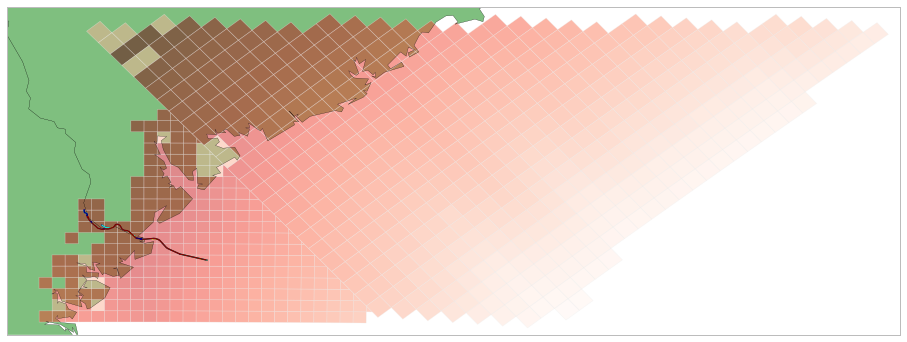

In [16]:
fig = plt.figure(figsize=(16,10))
ax = plt.gca()
basemap_sc.drawstates(linewidth=0.15)
basemap_sc.drawcoastlines(linewidth=0.25)
basemap_sc.fillcontinents(zorder=-1, color='green', alpha=0.5)

HabModelEnviroSC.plot(column='isomar12b', k=5, colormap='Reds', linewidth=0, axes=ax)
navchannelWGS84.plot(column='Color', axes=ax)

Import survey data

In [17]:
HabModelSurvey = gpd.GeoDataFrame.from_file('data/HabModelSurvey.shp')

Reproject to WGS84

In [18]:
HabModelSurveyWGS84 = HabModelSurvey.to_crs({'proj': 'longlat', 'ellps': 'WGS84', 'datum': 'WGS84'})

Clip to area of interest

In [19]:
HabModelSurveySC = HabModelSurveyWGS84[(lower_limit < HabModelSurveyWGS84.Lat) 
                                       & (HabModelSurveyWGS84.Lat < upper_limit)]

Sample plot of groups sighted for an arbitrary period

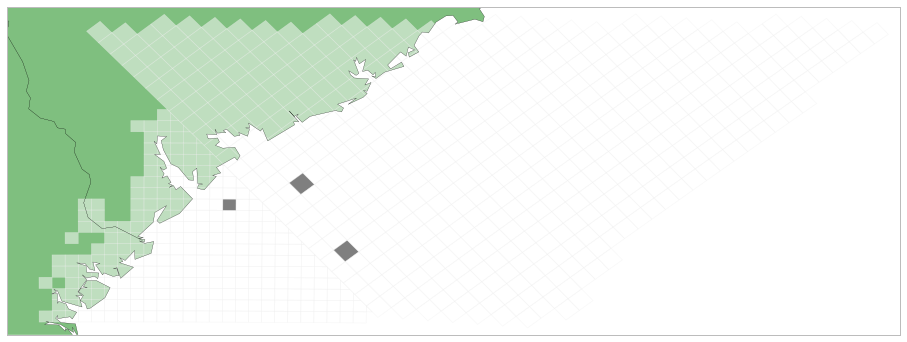

In [20]:
import matplotlib
binary_cm = matplotlib.colors.ListedColormap(np.array([[255,255,255], [0,0,0]])/255)

fig = plt.figure(figsize=(16,12))
ax = plt.gca()
basemap_sc.drawstates(linewidth=0.15)
basemap_sc.drawcoastlines(linewidth=0.25)
basemap_sc.fillcontinents(zorder=-1, color='green', alpha=0.5)

HabModelSurveySC.plot(column='GrpsJan10B', k=2, colormap=binary_cm, linewidth=0, axes=ax)

Perform a merge of survey and habitat data

In [21]:
# Use lower case for trailing A and B times
replace_dict = {c:c[:-1]+c[-1].lower() for c in HabModelEnviroSC.columns if c.endswith('A') or c.endswith('B')}
HabModelEnviro_points = HabModelEnviroSC.copy().rename(columns=replace_dict)
HabModelEnviro_points.geometry = HabModelEnviro_points.geometry.centroid

In [22]:
from geopandas.tools import sjoin

replace_dict = {c:c[:-1]+c[-1].lower() for c in HabModelSurveySC.columns if c.endswith('A') or c.endswith('B')}
HabModel_merged = sjoin(HabModelSurveySC.rename(columns=replace_dict), HabModelEnviro_points, how="left")

In [23]:
# Drop cells with null DistToShor values (land)
HabModel_merged = HabModel_merged.dropna(subset=['DistToShor'])

Buffer distance to shore

In [24]:
HabModel_merged = HabModel_merged[HabModel_merged.DistToShor>1000]

Convert data into long format and remove time information from column names. We are breaking the data into one table for each 2-week period.

In [25]:
time_intervals = ['Dec03a','Dec03b','Dec04a','Dec04b','Dec05a','Dec05b','Dec06a','Dec06b','Dec07a','Dec07b',
         'Dec08a','Dec08b','Dec09a','Dec09b','Dec10a','Dec10b','Dec11a','Dec11b','Dec12a','Dec12b',
         'Feb04a','Feb04b','Feb05a','Feb05b','Feb06a','Feb06b','Feb07a','Feb07b','Feb08a','Feb08b',
         'Feb09a','Feb09b','Feb10a','Feb10b','Feb11a','Feb11b','Feb12a','Feb12b','Feb13a','Feb13b',
         'Jan04a','Jan04b','Jan05a','Jan05b','Jan06a','Jan06b','Jan07a','Jan07b','Jan08a','Jan08b',
         'Jan09a','Jan09b','Jan10a','Jan10b','Jan11a','Jan11b','Jan12a','Jan12b','Jan13a','Jan13b',
         'Mar04a','Mar04b','Mar05a','Mar05b','Mar06a','Mar06b','Mar07a','Mar07b','Mar08a','Mar08b',
         'Mar09a','Mar09b','Mar10a','Mar10b','Mar11a','Mar11b','Mar12a','Mar12b','Mar13a','Mar13b']

data_types = ['Eff', 'Grps', 'Whls', 'iso', 'sst']

In [26]:
months = {'Dec':0, 'Jan':1, 'Feb':2, 'Mar':3}
fortnights = {'a':0, 'b':1}

Create unique cell ID

In [27]:
working_dataset = HabModel_merged.reset_index(level=0).rename(columns={'index':'quad_id'})

Create columns for 2-week period, year and time.

In [28]:
bimonthly_subsets = []
for t in time_intervals:
    # Build column name list
    cols = ['quad_id', 'geometry', 'DistToShor', 'MEAN_depth']
    n_fixed = len(cols)
    cols += [d+t for d in data_types[:-2]]
    cols += [d+t.lower() for d in data_types[-2:]]
    
    # Remove year time data from column labels
    subset = working_dataset[cols].rename(columns=dict(zip(cols[n_fixed:], data_types)))
    
    # Add time data
    month = months[t[:3]]
    year = int(t[3:-1])
    if not month:
        year +=1
    fortnight = fortnights[t[-1]]
    period = month*2 + fortnight
    
    subset['period'] = period
    subset['year'] = year - 3
    subset['time'] = t
    
    bimonthly_subsets.append(subset)

Concatenate subsets into single dataset

In [29]:
working_data_long = pd.concat(bimonthly_subsets, ignore_index=True)

Confirm that the resulting dataset is the same shape

In [30]:
assert sum([b.shape[0] for b in bimonthly_subsets]) == working_data_long.shape[0]

Add centroid coordinates for Gaussian process spatial model

In [31]:
centroids = pd.DataFrame(working_data_long.geometry.apply(lambda x: dict(zip(['lat','lon'], np.ravel(x.centroid.xy)))).tolist(),
            index=working_data_long.index)

In [32]:
working_data_long = working_data_long.join(centroids)

Extract shipping exposure data

In [33]:
transits['start_time'] = pd.to_datetime(transits.TR_START, 'D')

Filter out ineligible transits (Dec-Mar only)

In [34]:
transits = transits[transits.start_time.apply(lambda x: (x.month in (12, 1, 2, 3)) and (x.date()<date(2013, 4, 1)))]

In [35]:
transit_times = transits.start_time.astype(object)

In [36]:
month_lookup = {12: 'Dec', 1: 'Jan', 2: 'Feb', 3: 'Mar'}

In [37]:
transits['time'] = transit_times.apply(lambda t: month_lookup[t.month] + str(t.year)[-2:] + ['a','b'][t.day>14])

Drop 2003, given the above, and recode year.

In [38]:
working_data_long['year'] = working_data_long.year - 1
working_data_long = working_data_long[working_data_long.year > 0]

In [39]:
working_data_long.head()

quad_id                                           geometry  DistToShor  \
1210        4  POLYGON ((-81.0638121503616 31.66385317360051,...    3863.834   
1211        5  POLYGON ((-81.00520442711309 31.66387073674769...    9203.932   
1212        6  POLYGON ((-80.94659696259843 31.66386003275813...   12499.129   
1213        7  POLYGON ((-80.8879895953431 31.66382227576766,...   16670.382   
1214        8  POLYGON ((-80.82938237672916 31.66375760271118...   21411.103   

      MEAN_depth        Eff  Grps  Whls           iso     sst  period  year  \
1210     -3.8095  15.846747     0     0  96621.078356  15.474       0     1   
1211     -5.6428   9.329810     1     2  92330.602241  15.940       0     1   
1212    -10.5952  11.931681     0     0  87950.966394  15.999       0     1   
1213    -12.4523  23.011338     0     0  83711.069405  16.519       0     1   
1214    -13.3809  23.367187     0     0  79633.234672  16.930       0     1   

        time        lat        lon  
1210  Dec04a -81.093142  31.688897  
1211  Dec04a -81.034518  31.688928  
1212  Dec04a -80.975895  31.688932  
1213  Dec04a -80.917272  31.688908  
1214  Dec04a -80.858649  31.688856

Intersect polygons with transits and count transit intersections with each polygon as metric of ship traffic

In [40]:
import_data = True

if not import_data:
    working_data_long['traffic'] = None
    for t in time_intervals:
        lines = [shape(g) for g in transits[transits.time==t].geometry]
        working_data_long.loc[working_data_long.time==t, 'traffic'] = working_data_long[
            working_data_long.time==t].geometry.apply(lambda x: sum([shape(x).intersects(g) for g in lines]))

    gpd.GeoDataFrame(working_data_long).to_file('working_data_long.shp')

In [41]:
if import_data:
    working_data_long = gpd.GeoDataFrame.from_file('working_data_long.shp')

In [42]:
unique_geometries = working_data_long.loc[(working_data_long.period==0) & (working_data_long.time=='Dec04a'), 
                                          ['quad_id', 'geometry']].set_index('quad_id')
unique_geometries.shape

(605, 1)

Agregate sightings and effort across all time periods

In [43]:
df_sum = gpd.GeoDataFrame(working_data_long.groupby('quad_id')[
    ['Whls', 'Grps', 'Eff']].sum().join(unique_geometries, how='left'))

In [44]:
df_sum['whale_rate'] = df_sum.Whls/df_sum.Eff
df_sum['group_rate'] = df_sum.Grps/df_sum.Eff

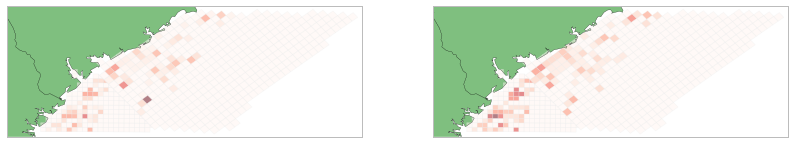

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(14,12))

basemap_sc.drawstates(linewidth=0.15, ax=axes[0])
basemap_sc.drawcoastlines(linewidth=0.25, ax=axes[0])
basemap_sc.fillcontinents(zorder=-1, color='green', alpha=0.5, ax=axes[0])
df_sum.plot(column='whale_rate', colormap='Reds', linewidth=0, axes=axes[0])

basemap_sc.drawstates(linewidth=0.15, ax=axes[1])
basemap_sc.drawcoastlines(linewidth=0.25, ax=axes[1])
basemap_sc.fillcontinents(zorder=-1, color='green', alpha=0.5, ax=axes[1])
df_sum.plot(column='group_rate', colormap='Reds', linewidth=0, axes=axes[1])

Vessel traffic maps for an arbitrary period

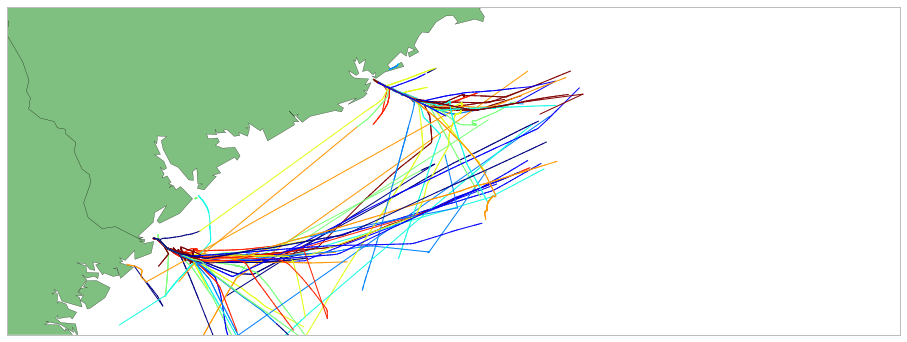

In [23]:
fig = plt.figure(figsize=(16,12))
ax = plt.gca()
basemap_sc.drawstates(linewidth=0.15)
basemap_sc.drawcoastlines(linewidth=0.25)
basemap_sc.fillcontinents(zorder=-1, color='green', alpha=0.5)

transits[transits.time=='Dec11b'].plot(axes=ax, alpha=0.2)

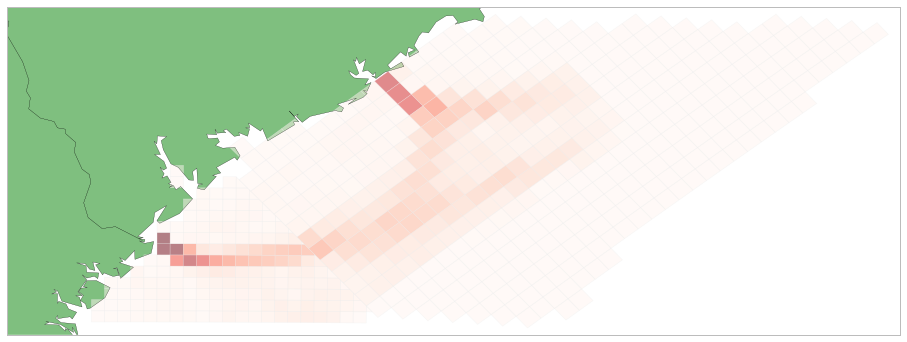

In [73]:
fig = plt.figure(figsize=(16,12))
ax = plt.gca()
basemap_sc.drawstates(linewidth=0.15)
basemap_sc.drawcoastlines(linewidth=0.25)
basemap_sc.fillcontinents(zorder=-1, color='green', alpha=0.5)

gpd.GeoDataFrame(working_data_long[working_data_long.time=='Jan13a']).plot(column='traffic', 
                                                                           colormap='Reds', linewidth=0, axes=ax)

In [46]:
dataset = working_data_long[~((working_data_long.Eff==0) & (working_data_long.Grps>0)) 
                            & working_data_long.sst.notnull() & working_data_long.MEAN_depth.notnull()]

# Include rows with positive effort
not_missing = dataset.Eff>0
dataset_surveyed = dataset[not_missing]
# Rows with zero effort is treated as missing data, to be predicted
missing_data = dataset[~not_missing]
centroids = dataset[['lat', 'lon']].values

This map shows relative mean survey effort in the region.

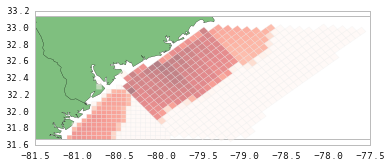

In [47]:
df_geo = dataset.groupby('quad_id')

test = dataset[(dataset.year==5) & (dataset.period==5)].copy()
test = test.set_index(test.quad_id)

test['total_groups'] = df_geo['Grps'].sum()
test['mean_effort'] = df_geo['Eff'].mean()

basemap_sc.drawstates(linewidth=0.15)
basemap_sc.drawcoastlines(linewidth=0.25)
basemap_sc.fillcontinents(zorder=-1, color='green', alpha=0.5)
gpd.GeoDataFrame(test).plot(column='mean_effort', colormap='Reds', linewidth=0)

## Spatial GLM via Gaussian Process

One of the key features of this analysis is the modeling of spatial autocorrelation via Gaussian processes. Since the number of surveys and sightings are limited, we need to borrow strength among the grid cells of the region, recognizing that an animal observed in one cell is likely to also be in neighboring cells within the same period. The Gaussian process models the spatial covariance directly, here estimating a risk surface of whale occurrence.

In [75]:
from pymc import Normal, Exponential, Uniform, Uninformative, Bernoulli, Poisson
from pymc import Lambda, MCMC, invlogit, deterministic, AdaptiveMetropolis, MCMC, normal_like, stochastic
from pymc.gp import *

Create mesh of area from grid centroids.

In [49]:
latmin, lonmin = centroids.min(0)
latmax, lonmax = centroids.max(0)
grid = np.meshgrid(np.linspace(lonmin, lonmax), np.linspace(latmin, latmax))
geo_mesh = np.vstack((np.ravel(grid[0]), np.ravel(grid[1]))).T*np.pi/180.

Extract columns of interest from dataset.

In [50]:
(lat, lon, period, year, sst, iso, traffic, depth) = dataset[
    ['lat', 'lon', 'period', 'year', 'sst', 'iso', 'traffic', 'MEAN_depth']].values.T
period = period.astype(int)

Use grouped dataset to extract summary values for each polygon

In [51]:
df_geo = dataset.groupby('quad_id')

In [52]:
# Columns that need to be averaged
data_summarized = df_geo[['lat', 'lon', 'sst', 'iso', 'MEAN_depth']].mean()
# Columns that need to be summed
data_summarized[['traffic', 'Grps', 'Whls', 'Eff']] = df_geo[['traffic', 'Grps', 'Whls', 'Eff']].sum()
data_summarized.head()

lat        lon        sst            iso  MEAN_depth  traffic  \
quad_id                                                                        
4       -81.093142  31.688897  13.256247  119200.031023     -3.8095        4   
5       -81.034518  31.688928  13.469918  114477.800710     -5.6428       13   
6       -80.975895  31.688932  13.618718  109732.472247    -10.5952       25   
7       -80.917272  31.688908  13.738225  104984.253630    -12.4523       33   
8       -80.858649  31.688856  13.886081  100228.491291    -13.3809       40   

         Grps  Whls          Eff  
quad_id                           
4           0     0  1870.059657  
5           1     2  2388.797729  
6           0     0  2389.803678  
7           2     3  2350.584436  
8           1     1  2304.253170

In [53]:
data_summarized.isnull().sum()

lat           0
lon           0
sst           0
iso           0
MEAN_depth    0
traffic       0
Grps          0
Whls          0
Eff           0
dtype: int64

In [70]:
groups, whales, effort = data_summarized[['Grps', 'Whls', 'Eff']].values.T
year = year.astype(int)
groups = groups.astype(int)

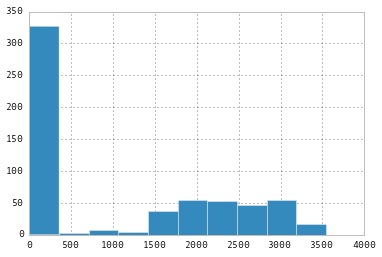

In [55]:
data_summarized.Eff.hist()

Scale effort by a factor of 100

In [56]:
effort = effort/100.

Indicator for unsurveyed polygons

In [57]:
unsurveyed_polygons = data_summarized.Eff==0

Normalize SST, ISO and depth

In [58]:
normalize = lambda x: np.array((x - x.mean()) / x.std())

In [59]:
sst_norm = normalize(data_summarized.sst)

In [60]:
iso_norm = normalize(data_summarized.iso)

In [61]:
depth_norm = normalize(data_summarized.MEAN_depth)

The response variable is the sighting of one or more groups.

In [62]:
y = groups > 0

This generates a Gaussian process submodel, which we will use to model spatial autocorrelation.

In [63]:
def make_gp_submodel(name, mesh):
    
    # Hyperparameters
    amp = Exponential('amp_%s'%name, .1, value=1.)
    scale = Exponential('scale_%s'%name, 1, value=.08)
    diff_degree = Exponential('diff_degree_%s'%name, 1, value=1)
    
    # Create the covariance & its evaluation at the data locations.
    @deterministic(trace=True,name='C_%s'%name)
    def C(amp=amp, scale=scale, dd=diff_degree):
        return FullRankCovariance(eval_fun = matern.euclidean, diff_degree=dd, amp=amp, scale=scale)
    
    @deterministic(trace=True, name='M_%s'%name)
    def M():
        return Mean(zero_fn)
    
    GP = GPSubmodel('GP_%s' % name, M, C, mesh=mesh)
    
    return locals()

In [64]:
sst_mesh = np.linspace(sst_norm.min(), sst_norm.max())
iso_mesh = np.linspace(iso_norm.min(), iso_norm.max())
depth_mesh = np.linspace(depth_norm.min(), depth_norm.max())

In [65]:
unique_centroids = data_summarized[['lat', 'lon']].values

Here is the hierarchical Bayesian model for whale encounter risk:

In [86]:
def risk_model():
    
    iso_gp = make_gp_submodel('iso', iso_mesh)
    beta_iso = Lambda('beta_iso', lambda b=iso_gp['GP'].f(iso_norm): b)
    
    depth_gp = make_gp_submodel('depth', depth_mesh)
    beta_depth = Lambda('beta_depth', lambda b=depth_gp['GP'].f(depth_norm): b)
    
    spatial_gp = make_gp_submodel('spatial', geo_mesh)
    beta_spatial = Lambda('beta_spatial', lambda b=spatial_gp['GP'].f(unique_centroids): b)
    
    gp_params = [iso_gp['amp'], iso_gp['scale'], iso_gp['diff_degree']]
    gp_params += [depth_gp['amp'], depth_gp['scale'], depth_gp['diff_degree']]
    gp_params += [spatial_gp['amp'], spatial_gp['scale'], spatial_gp['diff_degree']]

    # Occurrence rate
    @deterministic
    def θ(β0=beta_spatial, β1=beta_depth, β2=beta_iso):
        return np.exp(β0 + β1 + β2) 
    
    # Probability of detecting one or more groups
#     π = Lambda('π', lambda θ=θ: (1.0 - (1.0 - θ)**effort)[~unsurveyed_polygons.values])

    λ = Lambda('λ', lambda θ=θ: θ * effort)
        
    # Likelihood
    group_obs = Poisson('group_obs', λ, value=groups, observed=True)
    #occurrence = Bernoulli('occurrence', π, value=y[~unsurveyed_polygons.values], observed=True)
    
    risk = Lambda('risk', lambda theta=θ: theta*data_summarized.traffic.values)
               
    return locals()

Instantiate and run MCMC model

In [87]:
M = MCMC(risk_model())
M.use_step_method(AdaptiveMetropolis, M.gp_params)
# M.use_step_method(AdaptiveMetropolis, M.beta_period)

In [88]:
import appnope
appnope.nope()
M.sample(20000, 10000)

TypeError: Gaussian process GP_depth_f has no logp.

## Model output

The following graphical summaries show the posterior distribution of key parameters.

Estimated isotherm effect:

Plotting beta_iso_0
Plotting beta_iso_1


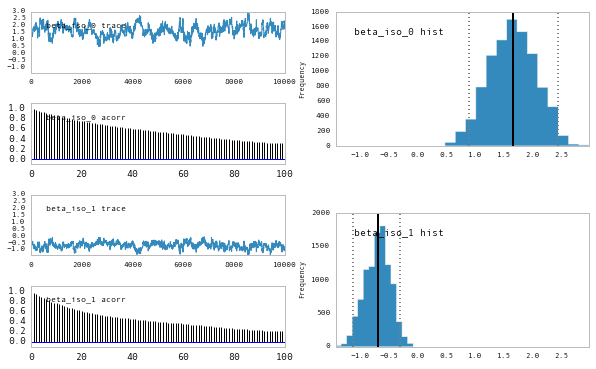

In [69]:
from pymc import Matplot

Matplot.plot(M.beta_iso)

Gaussian process hyperparameters

Plotting amp_spatial


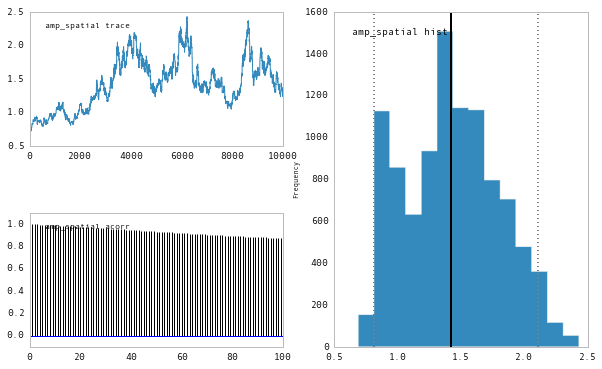

In [70]:
Matplot.plot(M.spatial_gp['amp'])

2-week period effects

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


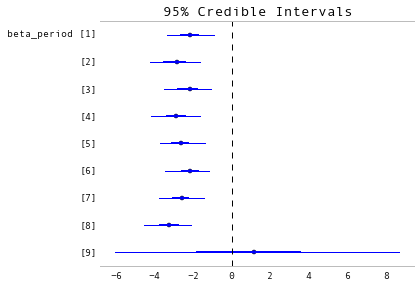

In [71]:
Matplot.summary_plot(M.beta_period)

Year effects

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


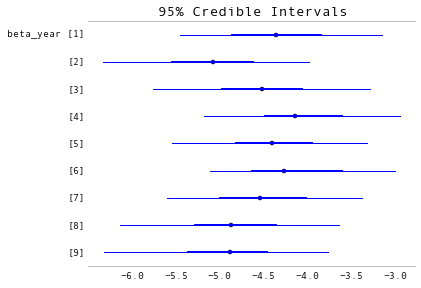

In [72]:
Matplot.summary_plot(M.beta_year)

In [73]:
dataset['risk'] = M.risk.stats()['mean']

In [77]:
dataset['p_pred'] = M.θ.stats()['mean']

In [169]:
dataset['gp_mean'] = M.beta_sp.stats()['mean']

This is an illustration of the Gaussian process, showing the spatial autocorrelation. 

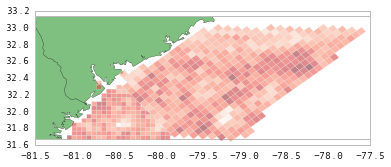

In [170]:
basemap_sc.drawstates(linewidth=0.15)
basemap_sc.drawcoastlines(linewidth=0.25)
basemap_sc.fillcontinents(zorder=-1, color='green', alpha=0.5)
gpd.GeoDataFrame(dataset[(dataset.year==5) & (dataset.period==5)]).plot(column='gp_mean', colormap='Reds', 
                                                                        linewidth=0)

In [74]:
period_labels = ['%s %s' % (period, month) for month in ('December', 'January', 'February', 'March') 
                 for period in ('Early', 'Late')]

In [103]:
def plot_year_by_month(year, column='p_pred', cmap='Reds'):

    f, axes = plt.subplots(4, 2, figsize=(12, 14))
    
    vmax = gpd.GeoDataFrame(dataset[(dataset.year==year)])[column].max()

    for i,ax in enumerate(axes.ravel()):
        basemap_sc.drawstates(linewidth=0.15, ax=ax)
        basemap_sc.drawcoastlines(linewidth=0.25, ax=ax)
        basemap_sc.fillcontinents(zorder=-1, color='green', alpha=0.5, ax=ax)
        gpd.GeoDataFrame(dataset[(dataset.year==year) & (dataset.period==i)]).plot(column=column, 
                                                                                colormap=cmap, vmin=0, vmax=vmax,
                                                                                linewidth=0, axes=ax)
        ax.set_title(period_labels[i])
        
    f.suptitle('Winter %s/%s' % (2003+year, 2004+year), fontsize=16)
    f.tight_layout()

This map shows predicted probabilities of occurrence across the region, for a particular year.

In [110]:
sample_year = 8

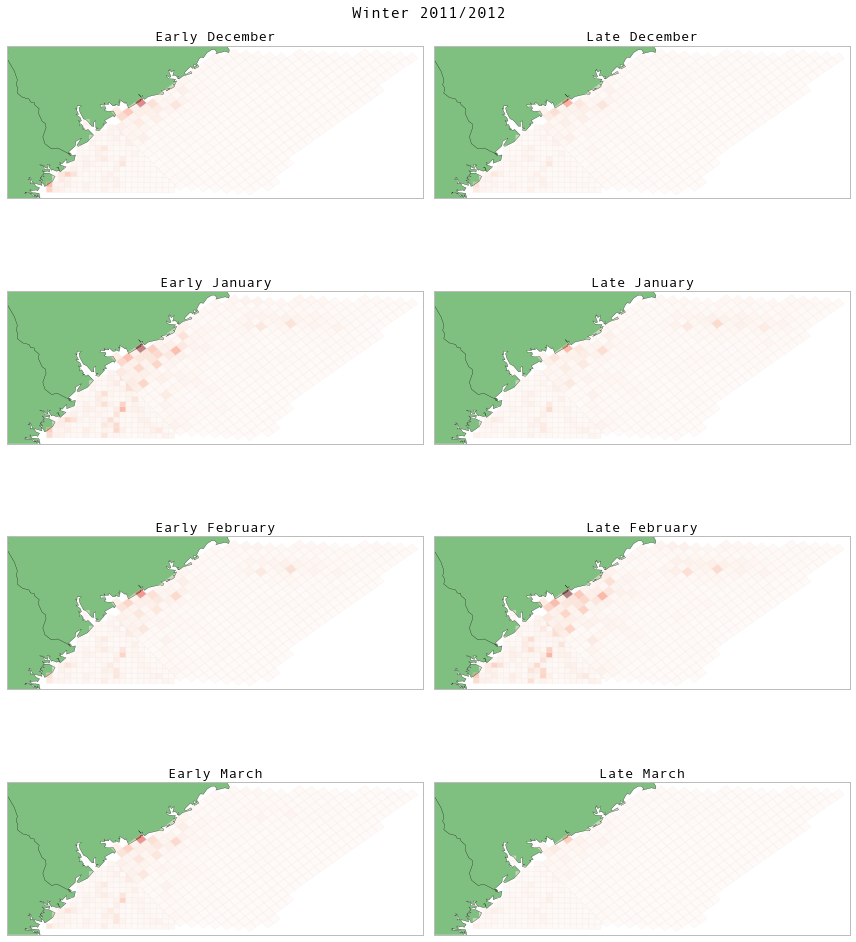

In [111]:
plot_year_by_month(sample_year, 'p_pred')

Here is a monthly map of traffic, for the same year

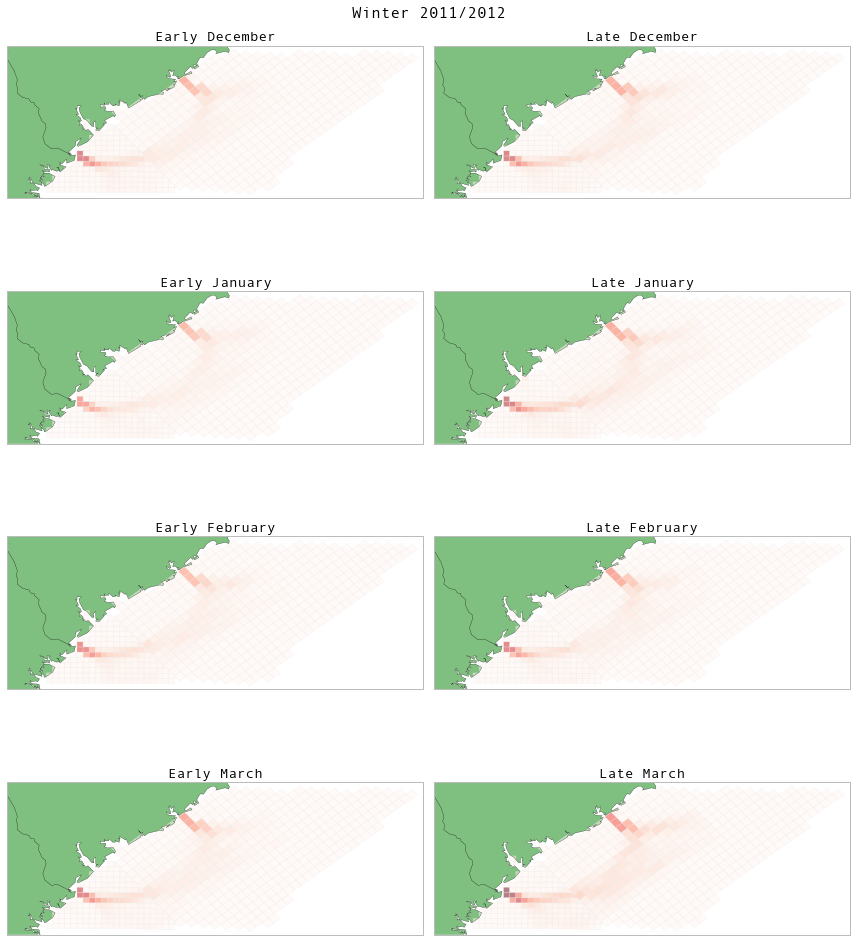

In [112]:
plot_year_by_month(sample_year, 'traffic')

There appears to be little spatial variation from month to month. Since the entrances to the ports dominate the heatmap above, here is the logarithm of the monthly traffic, which shows a similar pattern for the other cells.

In [101]:
dataset['log_traffic'] = np.log(dataset.traffic + 0.01)

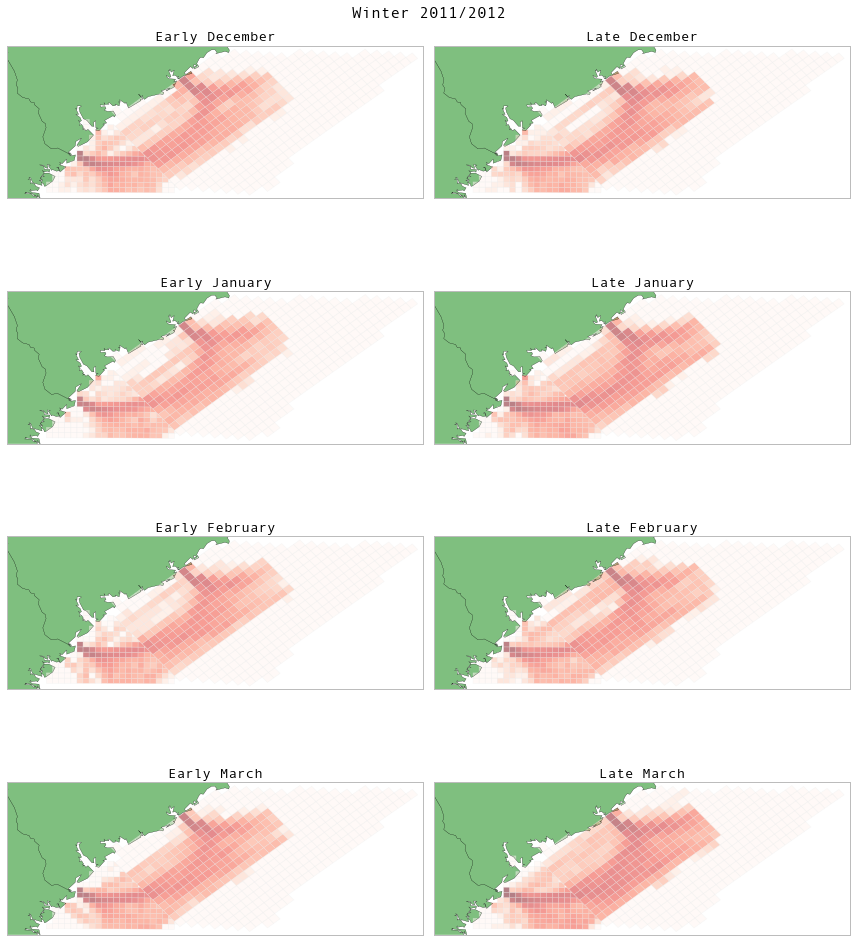

In [113]:
plot_year_by_month(sample_year, 'log_traffic')

This map combines predicted probabilities with ship traffic, to create a risk surface, for a given year.

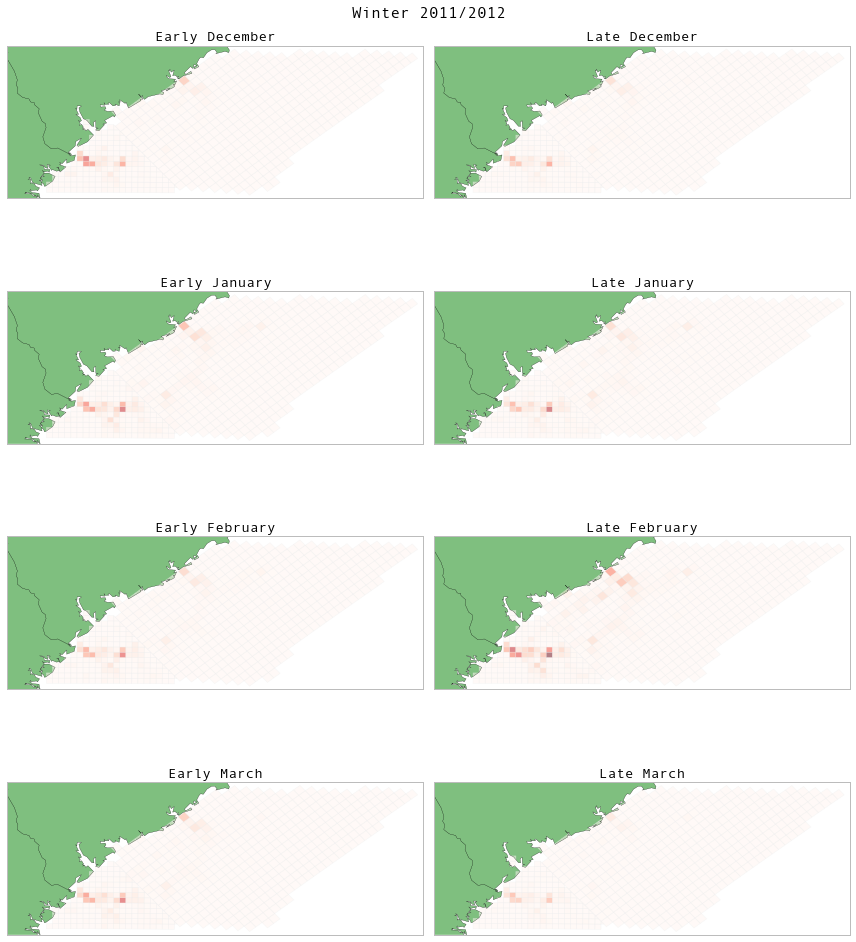

In [114]:
plot_year_by_month(sample_year, 'risk')

Again, to moderate the effects of the extreme areas, the risk with log-traffic.

In [115]:
dataset['lrisk'] = dataset.p_pred * dataset.log_traffic

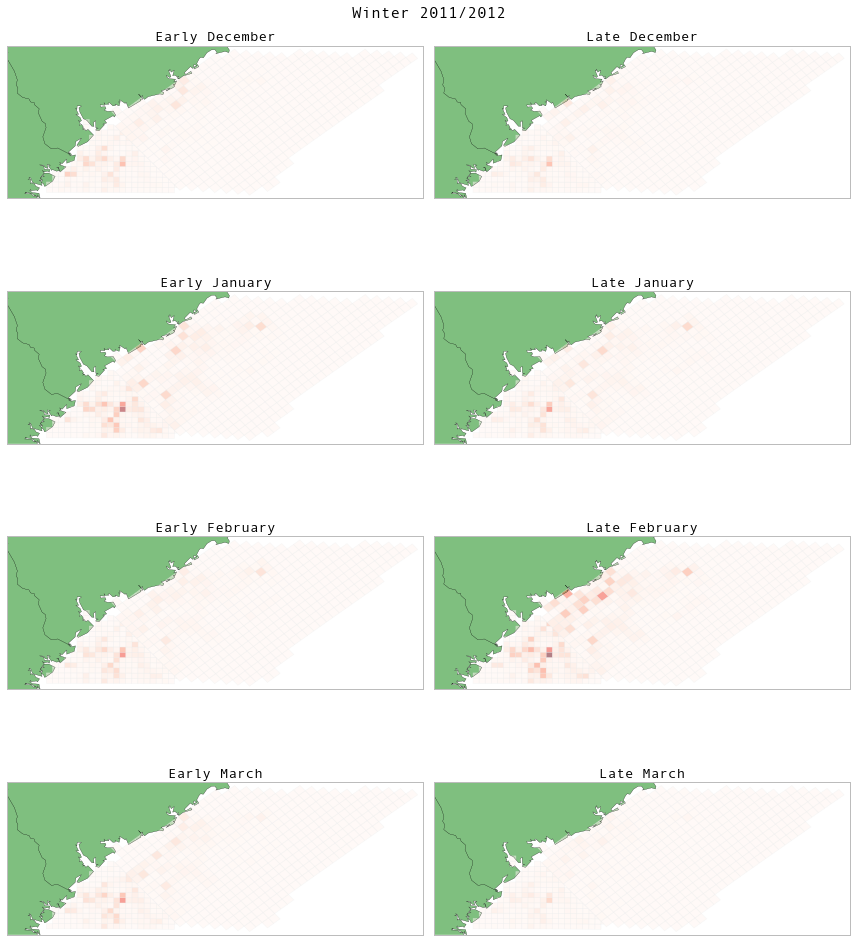

In [116]:
plot_year_by_month(sample_year, 'lrisk')

Finally, since there is likely to be preference for lanes that do not change over 2-week periods, the risk based on total traffic:

In [117]:
grouped_index = df_grouped['risk'].sum().index

In [118]:
p_pred = M.p_pred.stats()['mean']

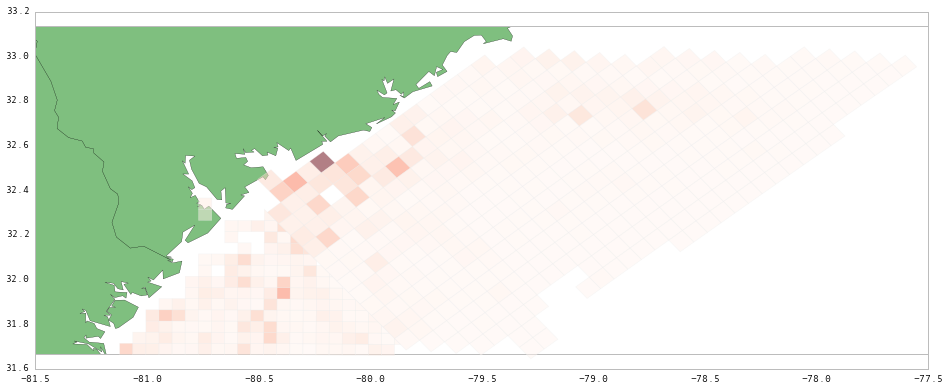

In [120]:
fig = plt.figure(figsize=(16,12))
ax = plt.gca()
basemap_sc.drawstates(linewidth=0.15)
basemap_sc.drawcoastlines(linewidth=0.25)
basemap_sc.fillcontinents(zorder=-1, color='green', alpha=0.5)
subset = dataset[(dataset.year==9) & (dataset.period==2)].set_index('quad_id')
geo_subset = gpd.GeoDataFrame(pd.concat([subset, pd.Series(p_pred, index=grouped_index)], axis=1, join='inner'))
geo_subset.plot(column=0, colormap='Reds', linewidth=0)


## Status and next steps

The estimates above are still preliminary, and the model is still a work in progress. However, the core of the model is now in place, pending model checks, and we can move to the process of selecting appropriate lanes given the predictions of the model. 

Questions:

- what is the appropriate width of the lane?
- is there a particular configuration that the lane should have? For example, should there be a Northern and Southern approach, to accomodate the types of traffic patterns that we see in the extant data?
- should the lanes be static, or temporally dynamic? I assume there would not be much appetite for lanes that change through the season?